<a href="https://colab.research.google.com/github/jgrandinetti/AI/blob/master/Chest_XRay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Dependencies
import numpy as np
import pandas as pd
import h5py
from keras import layers
from keras import models, Model
from keras import backend as K
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
from pathlib import Path
import cv2
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications import VGG16
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [0]:
!pip install kaggle

In [0]:
# Kaggle API Token
from google.colab import files
files.upload()

In [0]:
# File Config for Kaggle Data
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 1.14G/1.15G [00:13<00:00, 92.1MB/s]
100% 1.15G/1.15G [00:13<00:00, 89.2MB/s]


In [6]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          


In [0]:
!unzip chest_xray.zip

In [0]:
direct = Path("chest_xray/")

In [3]:
train_dir = direct / 'train'
valid_dir = direct / 'val'
test_dir = direct / 'test'

img_size = 224
batch_size = 30

generator = ImageDataGenerator(rescale = 1./255, horizontal_flip=True, vertical_flip=True, zoom_range=0.2)
train = generator.flow_from_directory(train_dir, shuffle=True, target_size = (img_size, img_size), batch_size = batch_size, class_mode ='categorical', subset='training')
valid = generator.flow_from_directory(valid_dir, shuffle=False, target_size = (img_size, img_size), batch_size = batch_size, class_mode ='categorical')
test = generator.flow_from_directory(test_dir, shuffle=False, target_size = (img_size, img_size), batch_size = batch_size, class_mode ='categorical')

train_labels = train.class_indices
valid_labels = valid.class_indices
test_labels = test.class_indices

print("-------------------------")
print("Training Labels")
print(train_labels)
print()
print("Validation Labels")
print(valid_labels)
print()
print("Testing Labels")
print(test_labels)
print("-------------------------")

pn = os.listdir(Path("chest_xray/train/PNEUMONIA/"))
nor = os.listdir(Path("chest_xray/train/NORMAL/"))

print("Pneumonia Images for Training:",len(pn))
print("Normal Images for Training:", len(nor))

cwr = len(pn) / len(nor)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
-------------------------
Training Labels
{'NORMAL': 0, 'PNEUMONIA': 1}

Validation Labels
{'NORMAL': 0, 'PNEUMONIA': 1}

Testing Labels
{'NORMAL': 0, 'PNEUMONIA': 1}
-------------------------
Pneumonia Images for Training: 3876
Normal Images for Training: 1342


In [0]:
# # First Attempt at Model
# conv_base = VGG16(include_top=False, input_shape=(img_size,img_size,3))
# conv_base.trainable = False
# x = (layers.Flatten())(conv_base.output)
# x = (layers.Dense(1024, activation='relu'))(x)
# x = (layers.Dropout(0.5))(x)
# x = (layers.Dense(512, activation='relu'))(x)
# x = (layers.Dropout(0.3))(x)
# x = (layers.Dense(2, activation='softmax'))(x)
# model = Model(inputs=conv_base.input, outputs =x )

# optimizer = Adam(lr=0.0001)
# class_weight = {0:cwr, 1:1}
# estop = EarlyStopping(patience=5)

# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# model.summary()

In [4]:
# Generate a model with all layers (with top)
vgg16 = VGG16(include_top=True)
vgg16.trainable = False

#Add a layer where input is the output of the  second last layer

x = Flatten()(vgg16.layers[-5].output)
x = (layers.Dense(64, activation='relu'))(x)
x = (layers.Dropout(0.4))(x)
x = (layers.Dense(2, activation='softmax'))(x)
model = Model(input=vgg16.input, output=x)

optimizer = Adam(lr=0.0001)
class_weight = {0:cwr, 1:1}
estop = EarlyStopping(patience=5)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


In [5]:
model_hist = model.fit_generator(train, steps_per_epoch = 200, epochs = 12, validation_data=valid, validation_steps = 10, class_weight = class_weight)#, callbacks=[estop])

Epoch 1/12
200/200 [==============================] - 210s 1s/step - loss: 0.4875 - acc: 0.8674 - val_loss: 0.8022 - val_acc: 0.6625
Epoch 2/12
200/200 [==============================] - 201s 1s/step - loss: 0.3379 - acc: 0.9095 - val_loss: 1.1545 - val_acc: 0.7562
Epoch 3/12
200/200 [==============================] - 203s 1s/step - loss: 0.2403 - acc: 0.9393 - val_loss: 0.5337 - val_acc: 0.8500
Epoch 4/12
200/200 [==============================] - 199s 993ms/step - loss: 0.2009 - acc: 0.9480 - val_loss: 0.6751 - val_acc: 0.8500
Epoch 5/12
200/200 [==============================] - 198s 991ms/step - loss: 0.1913 - acc: 0.9527 - val_loss: 0.3892 - val_acc: 0.8250
Epoch 6/12
200/200 [==============================] - 200s 998ms/step - loss: 0.1872 - acc: 0.9522 - val_loss: 0.3194 - val_acc: 0.8562
Epoch 7/12
200/200 [==============================] - 199s 996ms/step - loss: 0.1557 - acc: 0.9593 - val_loss: 0.1668 - val_acc: 0.9250
Epoch 8/12
200/200 [==============================] - 200

In [11]:
acc = model.evaluate_generator(test, steps=(len(test)))
x = acc[1]*100
y = acc[0]
print("Accuracy: %.2f%%" % x)
print("Loss: %.2f" % y)
print("------------------------")
print()
print()

test.reset()
Y_pred = model.predict_generator(test, 624 // batch_size+1)
classes = test.classes[test.index_array]
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test.classes[test.index_array],y_pred))
#print(confusion_matrix(test.classes, y_pred))
print('Classifications')
target_names = ['Normal', 'Penumonia']
print(classification_report(test.classes[test.index_array], y_pred, target_names=target_names))

Accuracy: 90.54%
Loss: 0.29
------------------------


Confusion Matrix
[[178  56]
 [  5 385]]
Classifications
             precision    recall  f1-score   support

     Normal       0.97      0.76      0.85       234
  Penumonia       0.87      0.99      0.93       390

avg / total       0.91      0.90      0.90       624



Actual: Pneumonia
Prediction: Pneumonia
Photo # 1


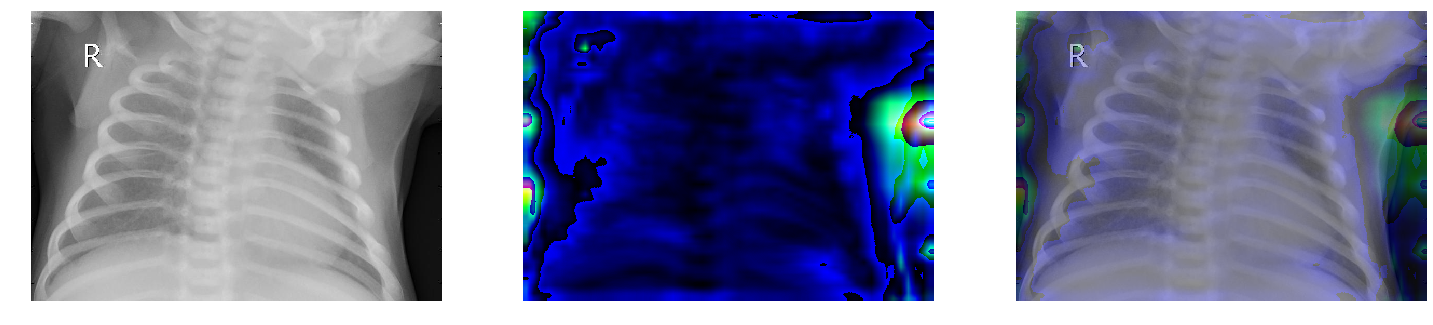

Actual: Pneumonia
Prediction: Pneumonia
Photo # 2


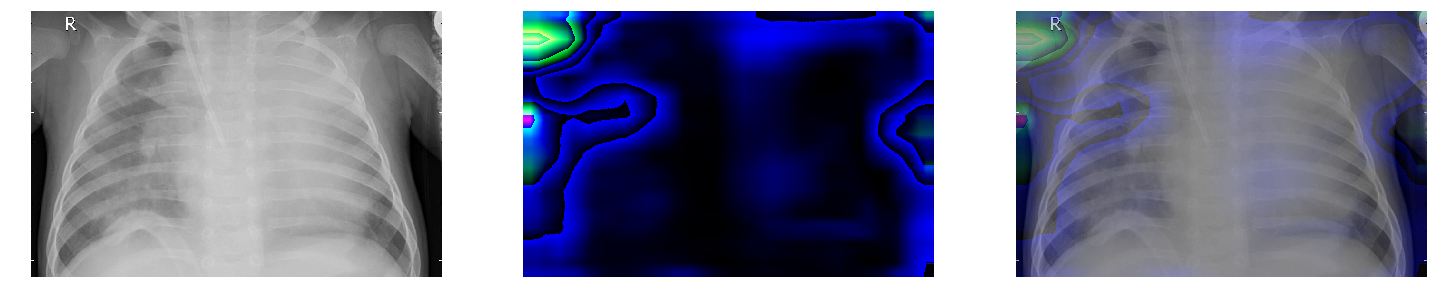

Actual: Pneumonia
Prediction: Normal
Photo # 3


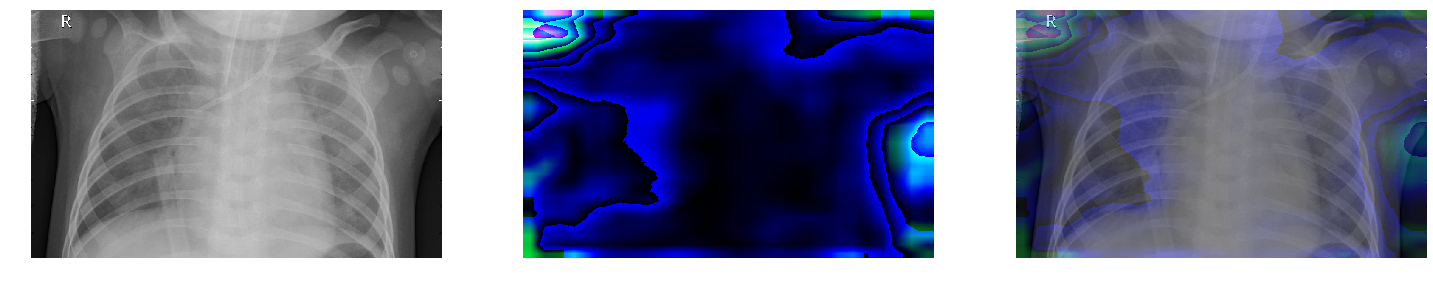

Actual: Normal
Prediction: Normal
Photo # 4


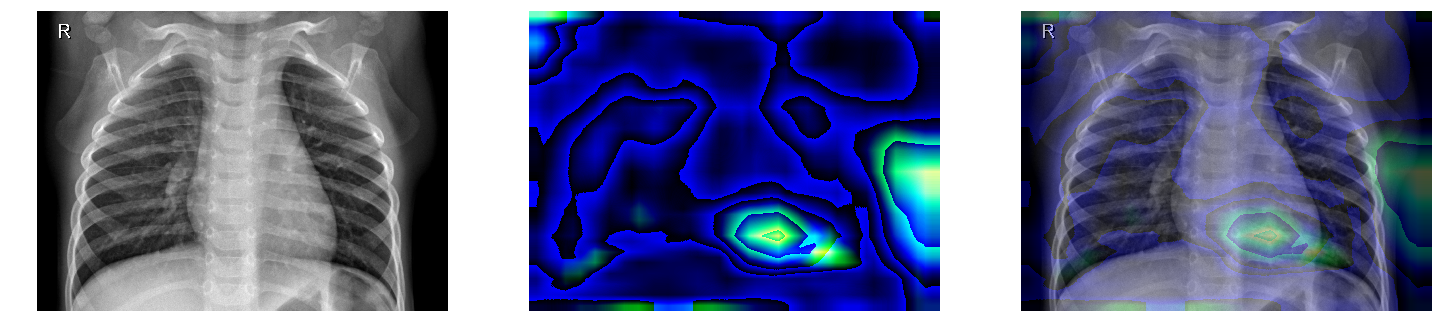

Actual: Normal
Prediction: Normal
Photo # 5


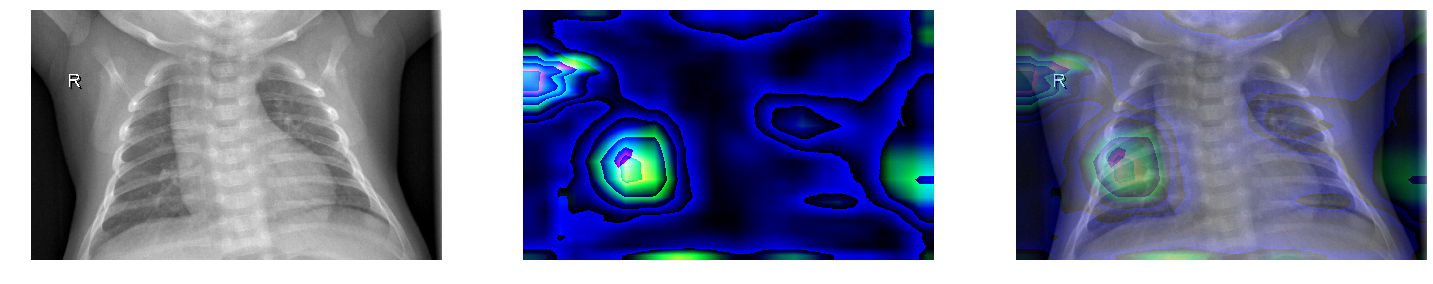

Actual: Normal
Prediction: Pneumonia
Photo # 6


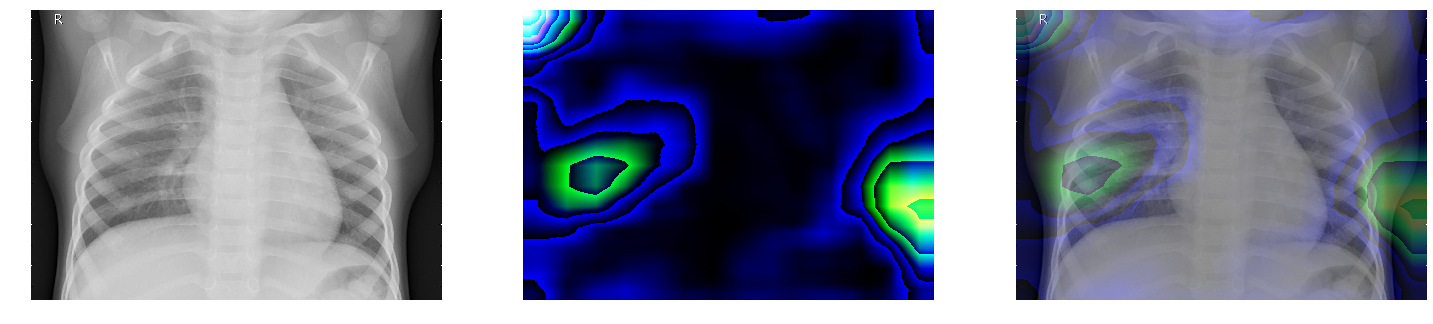

Actual: Pneumonia
Prediction: Pneumonia
Photo # 7


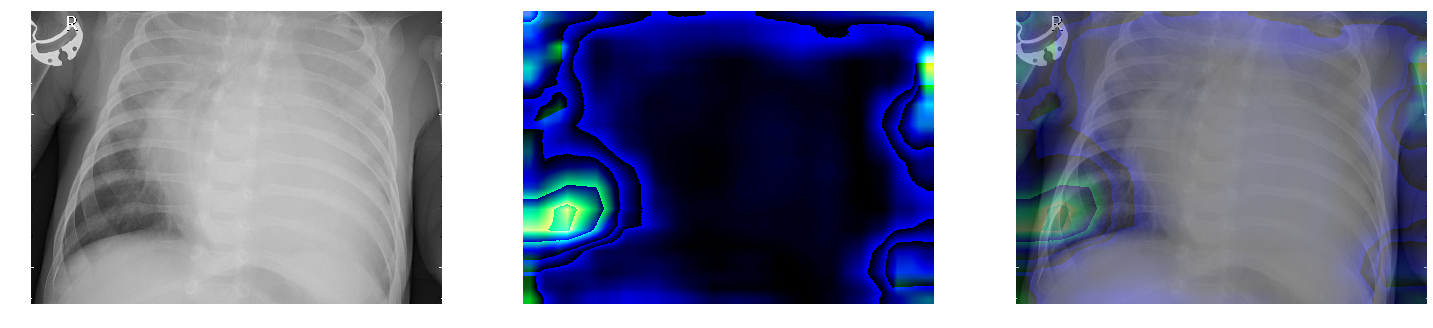

Actual: Normal
Prediction: Normal
Photo # 8


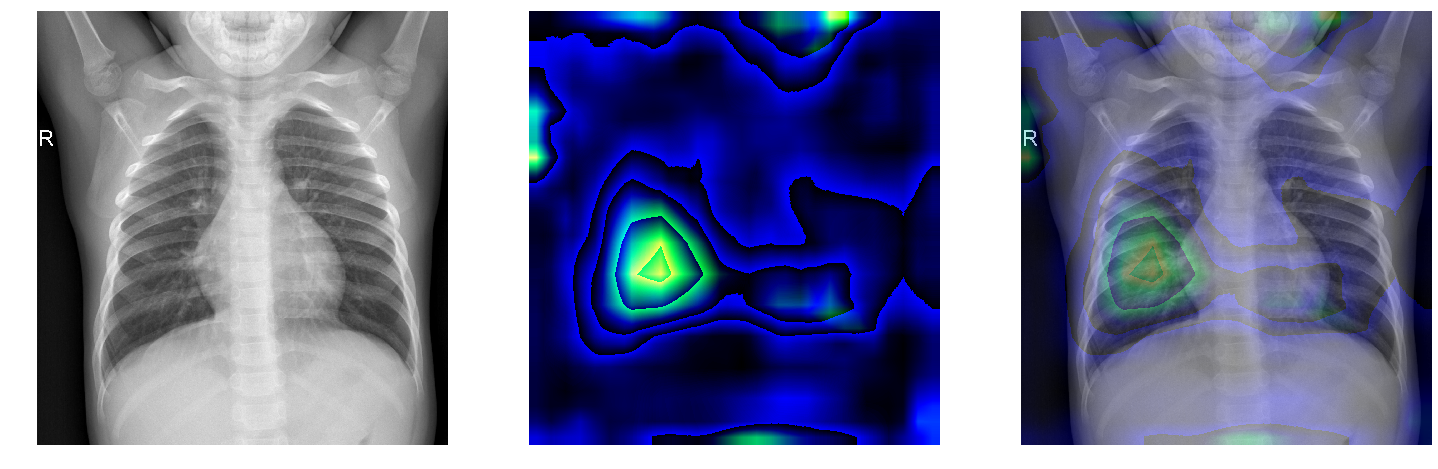

Actual: Normal
Prediction: Normal
Photo # 9


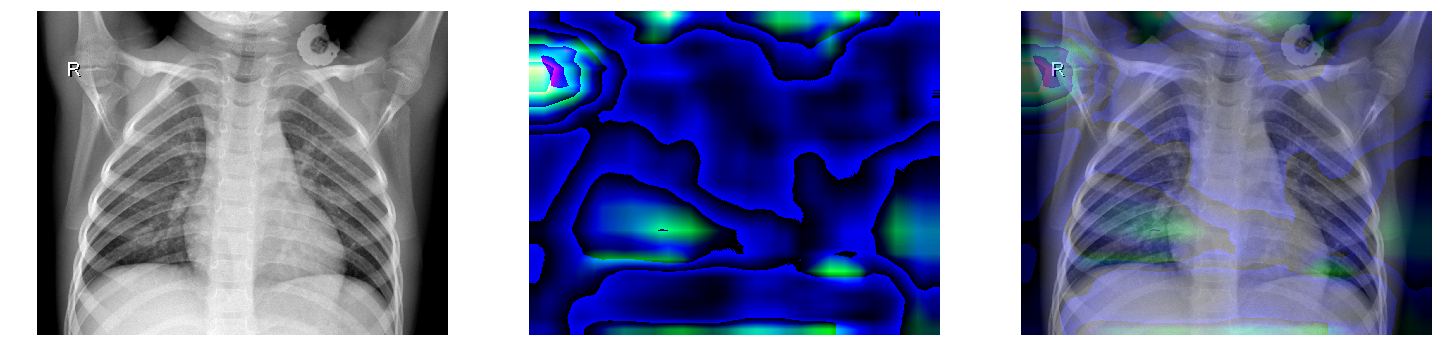

Actual: Normal
Prediction: Pneumonia
Photo # 10


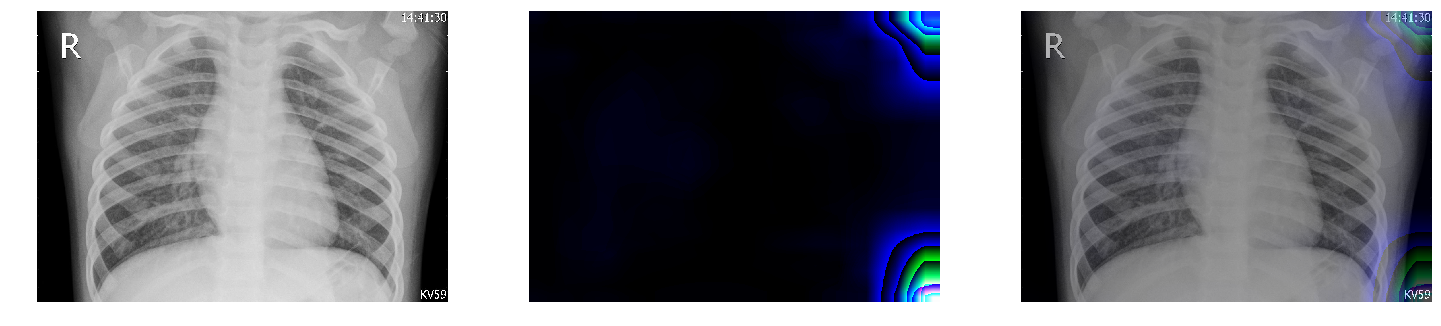

In [16]:
#np.random.seed(21)
cc = 1

conv = 'block3_conv3'
conv_size = 215 # starting Conv size
conv_up_size = 400
num_images_print = 10
num_layers = 3 # Number of convolutions to superimpose.

for xx in range(num_images_print):

  det_flow_type = np.random.randint(2)

  if det_flow_type == 0:
    flow_image = Path("chest_xray/test/NORMAL/")
    flow_type = "Normal"
  if det_flow_type == 1:
    flow_image = Path("chest_xray/test/PNEUMONIA/")
    flow_type = "Pneumonia"

  image = os.listdir(flow_image)

  image_num = np.random.randint(200)

  load_path = flow_image / image[image_num]

  img = load_img(load_path, target_size=(img_size, img_size))
  img_tensor = img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  x = preprocess_input(img_tensor)
  preds = model.predict(x)
  t = np.argmax(preds[0])
  img = cv2.imread(str(load_path))

  if t == 0:
    predic = "Normal"
  if t == 1:
    predic = "Pneumonia"  

  print("Actual:", flow_type)
  print("Prediction:", predic)
  print("Photo #", cc)
  cc += 1
  
  for zz in range(num_layers):
    flower_layer = model.output[:,t]
    last_conv_layer = model.get_layer(conv)
    grads = K.gradients(flower_layer, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(conv_size):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)

    if zz == 0:
      heatmap1 = heatmap
      conv = 'block4_conv3'
      conv_size = conv_up_size
    elif zz == 1:
      heatmap2 = heatmap
      conv = 'block5_conv3'
    elif zz == 2:
      heatmap3 = heatmap
      
  
  total_heatmap = heatmap1 + heatmap2 + heatmap3
      

  fig = plt.figure(xx, figsize=(25, 25))
  ax1 = fig.add_subplot(1,3,1)
  ax1 = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax1 = plt.grid(None)
  ax1 = plt.axis('off')

  ax2 = fig.add_subplot(1,3,2)
  ax2 = plt.imshow(total_heatmap)
  ax2 = plt.grid(None)
  ax2 = plt.axis('off')

  ax3 = fig.add_subplot(1,3,3)
  ax3 = plt.imshow(total_heatmap)
  ax3 = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), alpha=0.7)
  ax3 = plt.grid(None)
  ax3 = plt.axis('off')

  plt.show()